In [27]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib notebook


### Run methods

<IPython.core.display.Javascript object>


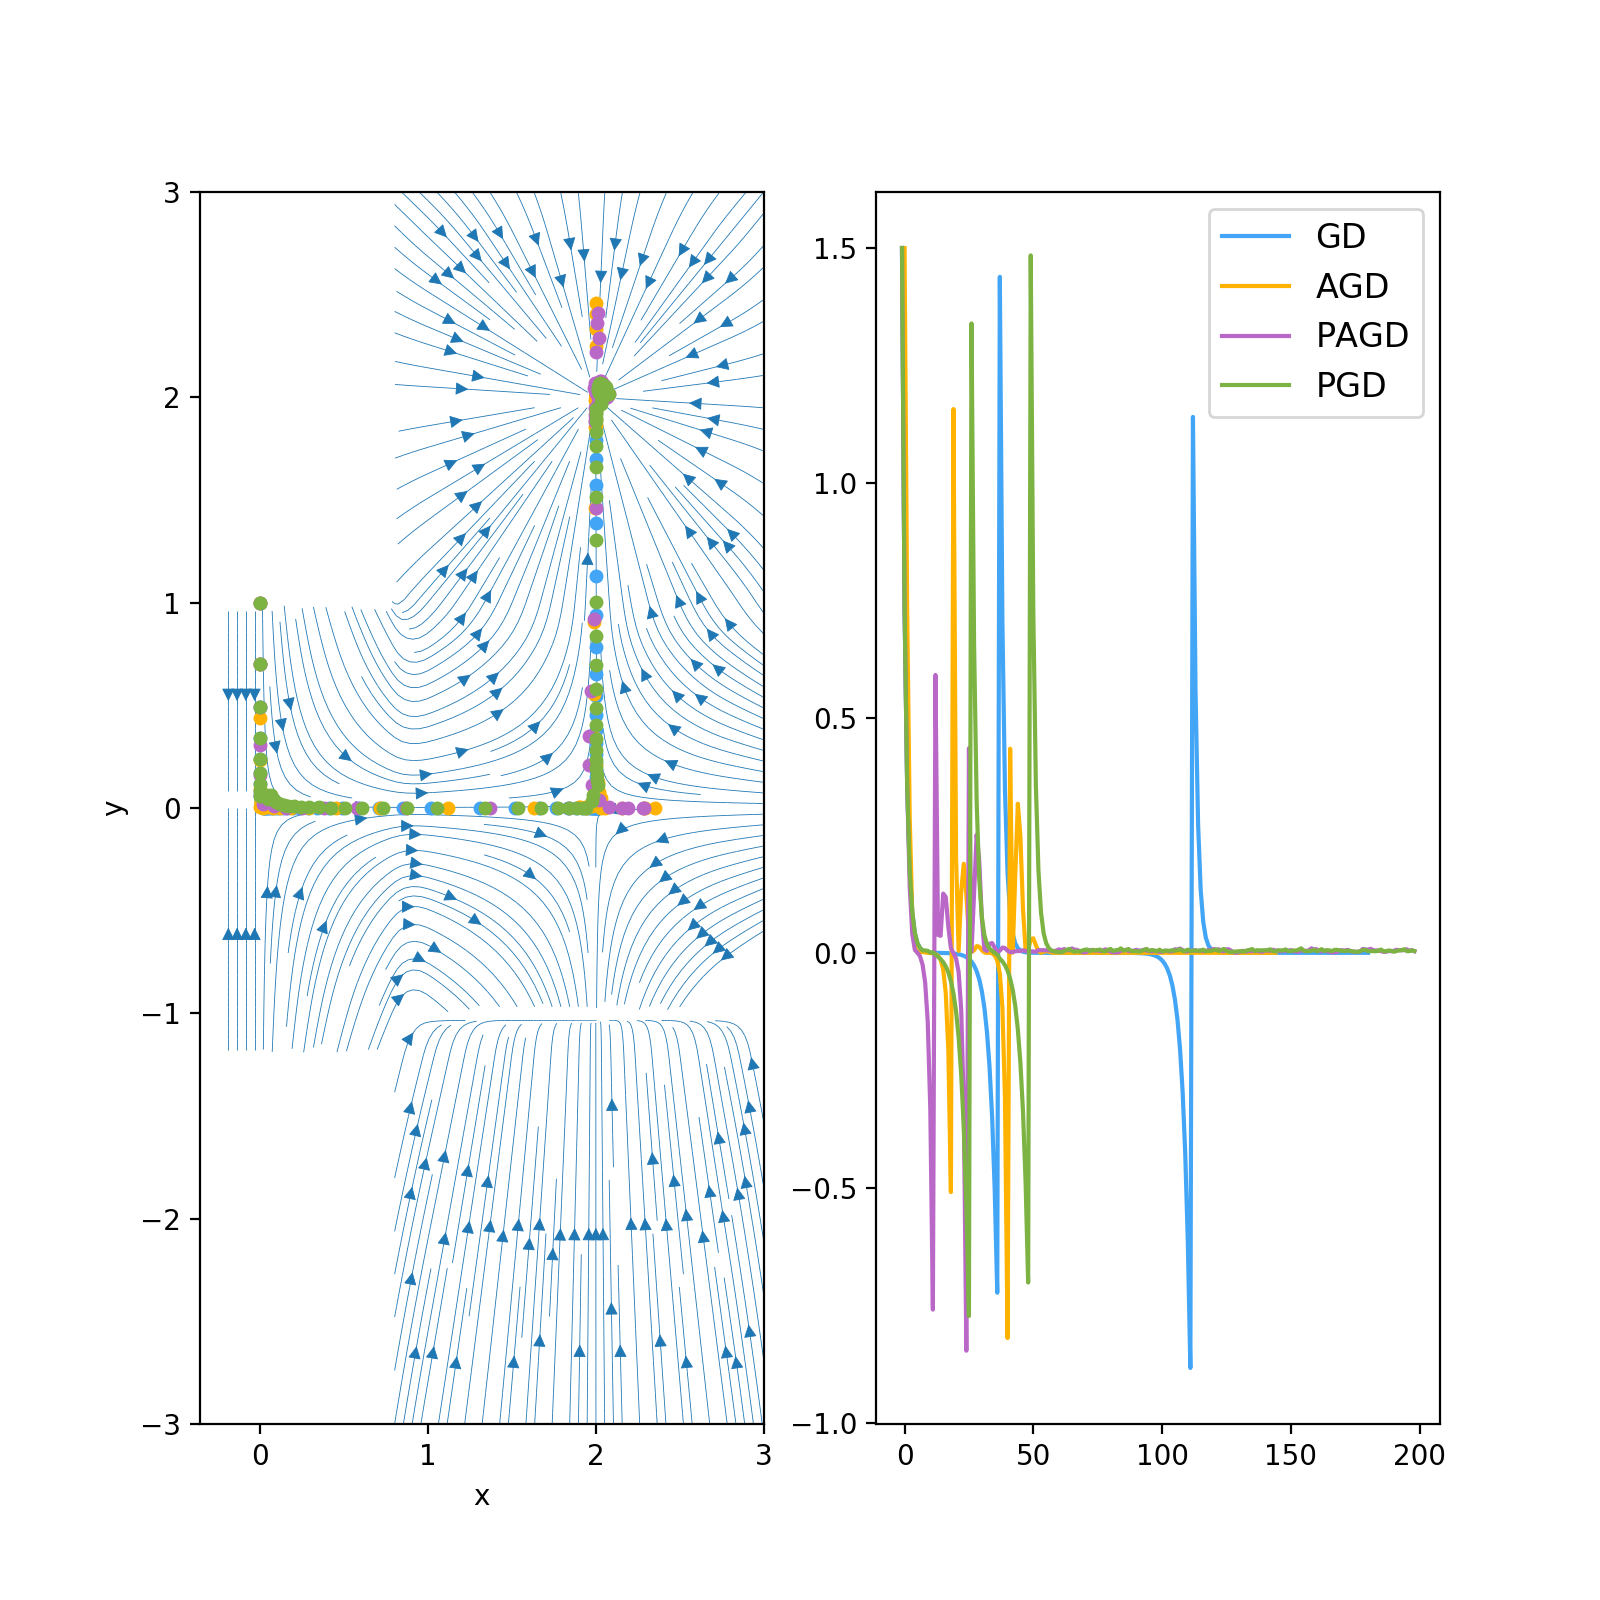

<IPython.core.display.Javascript object>


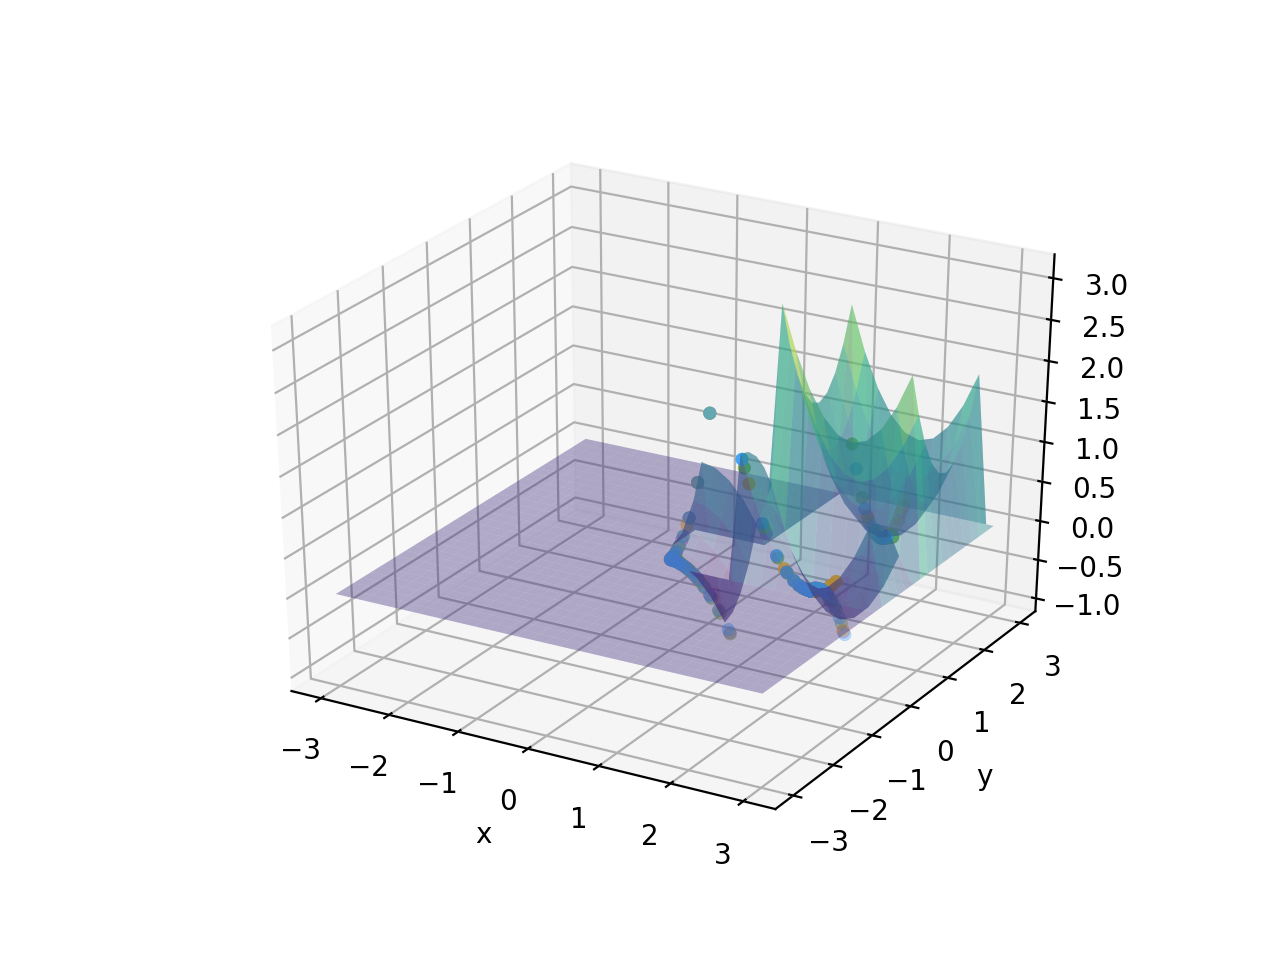

In [32]:
no_of_runs=1
iterations=200
accuracy=1e-10
step_size=0.1


global loss_type
#loss_type='coercive_saddle'
loss_type='tube'
list_loss = []
list_x = []
list_methods = []
list_steps = []
#plot limits
limits=np.array((-3,3))

GD=True
PGD=True
AGD=True
PAGD=True
Momentum=False

x_0=0.001
y_0=1
w_0=np.array((x_0,y_0))

if GD:
    if loss_type=='coercive_saddle':
        w_0=np.array((x_0,y_0))

    loss_collector=[]
    x_collector=[]
    for k in range(no_of_runs):
        (GD_steps,_x,_loss)= Gradient_Descent(w_0,iterations,step_size,accuracy)
        loss_collector.append(_loss)
        x_collector.append(_x)
    GD_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    GD_x =[float(sum(col))/len(col) for col in zip(*x_collector)]   
    
    list_loss.append(GD_loss)
    list_x.append(GD_x)
    list_methods.append('GD')
    list_steps.append(GD_steps)
 
if AGD:
    if loss_type=='coercive_saddle':
        w_0=np.array((-x_0,y_0))

    loss_collector=[]
    x_collector=[]
    for k in range(no_of_runs):
        (AGD_steps,_x,_loss)= Accelerated_Gradient_Descent(w_0,iterations,step_size,accuracy)
        loss_collector.append(_loss)
        x_collector.append(_x)
    AGD_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    AGD_x =[float(sum(col))/len(col) for col in zip(*x_collector)]   
    
    list_loss.append(AGD_loss)
    list_x.append(AGD_x)
    list_methods.append('AGD')
    list_steps.append(AGD_steps)

if PAGD:
    if loss_type=='coercive_saddle':
        w_0=np.array((-x_0,y_0))
    
    radius=0.05
    g_thres=0.2
    t_thres=1
    f_thres=-0.05  #if PGD ascends more than f_thres in t_thres iterations since pertubation->stop.
    loss_collector=[]
    x_collector=[]
    for k in range(no_of_runs):
        (PAGD_steps,_x,_loss)= Perturbed_Accelerated_Gradient_Descent(w_0,iterations,step_size,accuracy,t_thres, g_thres,f_thres,radius)
        loss_collector.append(_loss)
        x_collector.append(_x)
    PAGD_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    PAGD_x =[float(sum(col))/len(col) for col in zip(*x_collector)]   
    
    list_loss.append(PAGD_loss)
    list_x.append(PAGD_x)
    list_methods.append('PAGD')
    list_steps.append(PAGD_steps)
    
if Momentum:
    if loss_type=='coercive_saddle':
        w_0=np.array((-x_0,-y_0))

    loss_collector=[]
    
    x_collector=[]
    for k in range(no_of_runs):
        (Momentum_steps,_x,_loss)= Heavy_Ball(w_0,iterations,step_size,accuracy)
        loss_collector.append(_loss)
        x_collector.append(_x)
    Momentum_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    Momentum_x =[float(sum(col))/len(col) for col in zip(*x_collector)]   
    
    list_loss.append(Momentum_loss)
    list_x.append(Momentum_x)
    list_methods.append('Momentum')
    list_steps.append(Momentum_steps)

if PGD:
    if loss_type=='coercive_saddle':
        w_0=np.array((x_0,-y_0))
    radius=0.05
    g_thres=0.2
    t_thres=1
    f_thres=-0.05  #if PGD ascends more than f_thres in t_thres iterations since pertubation->stop.
    loss_collector=[]
    x_collector=[]
    for k in range(no_of_runs):
        opt_gap=compute_loss(w_0)-(-1/4)
        (PGD_steps,_x,_loss)= Pertubed_Gradient_Descent(w_0,iterations,step_size,accuracy,t_thres, g_thres,f_thres,radius)
        loss_collector.append(_loss)
        x_collector.append(_x)
    PGD_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    PGD_x =[float(sum(col))/len(col) for col in zip(*x_collector)]   
    
    list_loss.append(PGD_loss)
    list_x.append(PGD_x)
    list_methods.append('PGD')
    list_steps.append(PGD_steps)    
    
make_plot(list_loss,list_x,list_methods,list_steps,limits)


### some necessary functions:

In [16]:
 def compute_loss(w):
    if loss_type=='coercive_saddle':
        loss=0.5*w[0]**2+1/4*w[1]**4-0.5*w[1]**2
    elif loss_type=='tube':
        L=1.5
        gamma=1
        if 0<=w[0]<=1 and 0<=w[1]<=1:
            loss=-gamma*w[0]**2+L*w[1]**2
        elif 1<=w[0]<=3 and 0<=w[1]<=1:
            loss=L*(w[0]-2)**2-gamma*w[1]**2
        elif 1<=w[0]<=3 and 1<=w[1]<=3:
            loss=L*(w[0]-2)**2+L*(w[1]-2)**2
        else:
            loss=0
            
    else:
        raise ValueError("Unknown losstype!")
    
    return loss

def compute_gradients(w):
# forward pass

    if loss_type=='coercive_saddle':
        grad = np.array([w[0], w[1] ** 3 - w[1]])
    elif loss_type=='tube':
        L=1.5
        gamma=1
        if 0<=w[0]<=1 and 0<=w[1]<=1:
            grad = np.array([-2*gamma*w[0], 2*L* w[1]])
        elif 1<=w[0]<=3 and 0<=w[1]<=1:
            grad = np.array([2*L*(w[0]-2), -2*gamma* w[1]])
        elif 1<=w[0]<=3 and 1<=w[1]<=3:
            grad = np.array([2*L*(w[0]-2), 2*L*(w[1]-2)])
            
        #mirroring trick (no change, since x_2 components are switched automatically since x_2<0).. but something goes
        #wrong in the 3rd area.
        elif 0<=w[0]<=1 and 0<=-w[1]<=1:
            grad = np.array([-2*gamma*w[0],  2*L* w[1]])
        elif 1<=w[0]<=3 and 0<=-w[1]<=1:
            grad = np.array([2*L*(w[0]-2), -2*gamma* w[1]])   
        elif 1<=w[0]<=3 and 1<=-w[1]<=3:
            grad = np.array([2*L*(w[0]-2), 2*L*(w[1]-2)])
            
        else:
            grad=np.array([0,0])
    else:
        raise ValueError("Unknown losstype!")
        
    return grad



def make_plot(list_loss,list_x,list_methods,list_steps,limits):
    colors = ['#42A5F5', '#FFB300', '#BA68C8','#7CB342']

    s=0.2
    x_ax = np.arange(limits[0],limits[1]+s, s)  
    y_ax = np.arange(limits[0],limits[1]+s, s)  
    x_ax,y_ax = np.meshgrid(x_ax,y_ax)
    gradient_x=np.zeros((x_ax.shape[0],x_ax.shape[1]))
    gradient_y=np.zeros((y_ax.shape[0],y_ax.shape[1]))
    loss=np.zeros((x_ax.shape[0],x_ax.shape[1]))

    for i in range(x_ax.shape[0]):
        for j in range(x_ax.shape[1]):
            grad=compute_gradients(np.array((x_ax[i,j],y_ax[i,j])))
            gradient_x[i,j]=grad[0]
            gradient_y[i,j]=grad[1]
            loss[i,j]=compute_loss(np.array((x_ax[i,j],y_ax[i,j])))


    #1. Plot Gradient Flow
    plt.subplot(1, 2, 1)
        
    plt.streamplot(x_ax,y_ax,-gradient_x,-gradient_y, density=4, linewidth='0.3')
    plt.gcf().set_size_inches((8,8))
    plt.show()
    plt.xlabel('x')
    plt.ylabel('y')
    
    #Show iterates
    for i in range (len(list_loss)):
        plt.plot(np.array(list_steps[i])[:,0],np.array(list_steps[i])[:,1], 'o',color= colors[i],markersize='4',alpha=1)
    #plt.legend(list_methods,fontsize=12, loc=1)

    #2. Plot performance over time/steps
    plt.subplot(1, 2, 2)
    for i in range(len(list_loss)):
        plt.plot(list_x[i], list_loss[i],color= colors[i])
    plt.legend(list_methods,fontsize=12, loc=1)
    
    #3 .Plot Error Surface
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax = fig.gca(projection='3d')
    ax.plot_surface(x_ax, y_ax, loss,cmap='viridis', 
                    alpha=0.4,zorder=1)  
    # Show iterates
    for i in range(len(list_loss)):
        ax.scatter(np.array(list_steps[i])[:,0],np.array(list_steps[i])[:,1], list_loss[i],'o',color= colors[i],linewidth='0.25',zorder=i+2)

    plt.xlabel('x')
    plt.ylabel('y')



### Gradient Descent

In [6]:
# Run GD (simultaneously)
def Gradient_Descent(w,iterations,step_size,accuracy):
    iterates=[]
    loss=[]
    x=[]
    for k in range(iterations): 
        #safe information
        iterates.append(w)
        x.append(k-1)
        loss.append(compute_loss(w))
        
        #take step
        grad=compute_gradients(w)  
        w=w-step_size*grad
        if np.linalg.norm(grad)<accuracy:
            break

    return(iterates,x,loss)

### Accelerated Gradient Descent

In [31]:
#Run AGD
def Accelerated_Gradient_Descent(w,iterations,step_size, accuracy):
    iterates=[]
    loss=[]
    x=[]
    w_old=w

    for k in range(1,iterations+1): 
        iterates.append(w)
        x.append(k-1)
        loss.append(compute_loss(w))
        
        #compute y_(k)
        y=w+(k-1)/(k+2)*(w-w_old)
        if loss_type=='tube':
            if y[1]<0:
                y[1]=-y[1]
        #store x_(k-1)
        w_old=w
        #compute gradients
        grad=compute_gradients(y)
        w=y-step_size*grad
        if loss_type=='tube': #if no mirroring trick is used in gradients. apply here!
            if w[1]<0:
                print(' neg x_2')
            #    w[1]=-w[1]
 
        if np.linalg.norm(grad)<accuracy:

            break

    return(iterates,x,loss)

In [4]:
def Perturbed_Accelerated_Gradient_Descent(w,iterations,step_size,accuracy,t_thres, g_thres,f_thres,radius):
    iterates=[]
    loss=[]
    x=[]
    w_old=w
  
    t_noise=-t_thres-1
    eta=step_size
    
    for k in range(iterations): 
        #safe information
        iterates.append(w)
        x.append(k-1)
        loss_w=compute_loss(w)
        loss.append(loss_w)
        
        #compute y_(k)
        y=w+(k-1)/(k+2)*(w-w_old)
        if loss_type=='tube':
            if y[1]<0:
                y[1]=-y[1]
        #store x_(k-1)
        w_old=w
        #compute gradients
        grad=compute_gradients(y) 
        
        #Should we perturb the extrapolation point or rather x_k+1.. My guess is the extrapolation point.
        
        if np.linalg.norm(grad)<g_thres:
            #Sample 1 point uniformly form ball with radius r 
            p=radius*np.ones(w_0.shape[0])
            while np.linalg.norm(p)>radius:
                p = radius*np.random.normal(size=(1, w_0.shape[0]))[0]
                if loss_type=='coercive_saddle':
                    if  p[1]>0: #make PGD turn left! (just for illustrative purposes) 
                        p[1]=-p[1]
                elif loss_type=='tube':
                    if  p[0]<0: #make sure PGD stays within [0,3]x[0,3]
                        p[0]=-p[0]
                    if  p[1]<0: 
                        p[1]=-p[1]
             #   print(k,'AGD perturbing')
            _y=y
            t_noise=k
            y=_y+p
            grad=compute_gradients(y)  
            
        w=y-step_size*grad
        
        if loss_type=='tube':
            if w[1]<0:
                w[1]=-w[1]
    
        if np.linalg.norm(grad)<accuracy:
            break

    return(iterates,x,loss)

### Momentum

In [3]:
#Run Momentum
def Heavy_Ball(w,iterations,step_size, accuracy):
    iterates=[]
    loss=[]
    x=[]
    w_old=w

    for k in range(1,iterations+1): 
        iterates.append(w)
        x.append(k-1)
        loss.append(compute_loss(w))
        
        #compute y_(k)
        y=w+(k-1)/(k+2)*(w-w_old)
        #store x_(k-1)
        w_old=w
        #compute gradients
        grad=compute_gradients(w)
        w=y-step_size*grad
 
        if np.linalg.norm(grad)<accuracy:
            break

    return(iterates,x,loss)

### Pertubed Gradient Descent

In [2]:
# Run GD (simultaneously)
def Pertubed_Gradient_Descent(w,iterations,step_size,accuracy,t_thres, g_thres,f_thres,radius):
    iterates=[]
    loss=[]
    x=[]
  
    t_noise=-t_thres-1
    eta=step_size
    
    for t in range(iterations): 
        #safe information
        iterates.append(w)
        x.append(t-1)
        loss_w=compute_loss(w)
        loss.append(loss_w)
        
        grad=compute_gradients(w)  
        
        if np.linalg.norm(grad)<g_thres:
            #Sample 1 point uniformly form ball with radius r 
            p=radius*np.ones(w_0.shape[0])
            while np.linalg.norm(p)>radius:
                p = radius*np.random.normal(size=(1, w_0.shape[0]))[0]
                if loss_type=='coercive_saddle':
                    if  p[1]>0: #make PGD turn left! (just for illustrative purposes) 
                        p[1]=-p[1]
                elif loss_type=='tube':
                    if  p[0]<0: #make sure PGD stays within [0,3]x[0,3]
                        p[0]=-p[0]
                    if  p[1]<0: 
                        p[1]=-p[1]
             #   print(t,'GD perturbing')

            _w=w
            t_noise=t
            w=_w+p
            grad=compute_gradients(w)              
            
        #if t-t_noise==t_thres and loss_w-compute_loss(_w)>-f_thres: #stop pertubing around minimizers
        #    iterates[-1]=_w
        #    loss[-1]=compute_loss(_w)
        #    break
        
        w=w-eta*grad
        if np.linalg.norm(grad)<accuracy:
            break

    return(iterates,x,loss)